<a href="https://colab.research.google.com/github/amanvishnani/CSCI-6505/blob/master/ML_6505_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---


---

Name: Aman Vishnani

Banner Number: B00840115


---


---



In [0]:
import numpy as np
import math
from tqdm import tqdm
import warnings

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
def one_hot_vector(y, total_classes=None):
  m = y.shape[0]
  if total_classes is None:
    total_classes = y.max() + 1
  temp = np.zeros((m, total_classes))
  temp[np.arange(m), y.ravel()] = 1
  return temp

# **[20pts Total] Part 1: A Feedforward Neural Network**

##**a) [3pts] Create the data set**

##**b) [1pt] Add noise to the dataset**

In [0]:
def visualize_data(X):
  colors = ['g', 'r', 'b', 'y', 'm', 'w']
  x, y = X[:,:2], X[:, 2:]
  if y.shape[1] > 1:
    y = y.argmax(axis=1)
  else:
    y = y.ravel()
  classes = np.unique(y.ravel())
  scatter_plot = np.empty_like(y, dtype='str')
  for i in range(-1, len(classes)+1):
    scatter_plot[y==i] = colors[i]
  scatter_plot = scatter_plot.ravel()
  plt.scatter(x[:,0], x[:,1], c=scatter_plot)
  plt.show()

In [0]:
def generateData(numExamples, distributionShape='g', noise=0.0, num_classes=2):
  assert type(numExamples) is int, "Num Examples must be a scalar int value"

  assert type(distributionShape) is str, "distributionShape must be a string value"

  if distributionShape is "g":
    num_per_cluster = int(numExamples/num_classes)
    cluster_points = []
    labels = []
    for i in range(0, num_classes):
      C = np.random.normal(size=(num_per_cluster, 2)) + (3 * (i+1))
      label = np.ones((num_per_cluster,1))*i
      cluster_points.append(C)
      labels.append(label)
    x = np.vstack(cluster_points)
    y = np.vstack(labels)
  elif distributionShape is "c":
    x_range = np.linspace(-10, 10, numExamples*2)
    x_1, y_1 = np.meshgrid(x_range, x_range)
    x_1 = x_1.reshape(-1, 1)
    y_1 = y_1.reshape(-1, 1)
    x = np.hstack([x_1, y_1])
    y_val = (x[:,0])**2 + (x[:,1])**2
    y = np.zeros_like(y_val) - 1
    r = 1
    width = math.sqrt(2)
    for i in range(0, num_classes):
      if i is 0:
        class_i = y_val <= r**2
      else:
        class_i = (y_val >= r**2) & (y_val <= (r*width)**2)
        r = r * width
      y[class_i] = i
    y = y.reshape(-1, 1)
  else:
    raise Exception("Wrong distributionShape")
  all = np.hstack((x, y))
  all = all[(all[:, -1] != -1)]
  np.random.shuffle(all)
  all = all[:numExamples, :]
  x, y = all[:, :-1], all[:, -1, np.newaxis]
  r = np.random.rand(y.shape[0]).reshape(-1, 1)
  r = r <= noise
  for i in range(0, num_classes):
    y_is_i = y==i
    if i is not num_classes-1:
      y[(y_is_i & r)] = i+1
    else:
      y[(y_is_i & r)] = 0
  
  if num_classes > 2:
    y = y.astype(np.int64)
    y = one_hot_vector(y)
  all = np.hstack((x, y))
  return all

In [0]:
X = generateData(1000, "g", noise=0.02, num_classes=3)

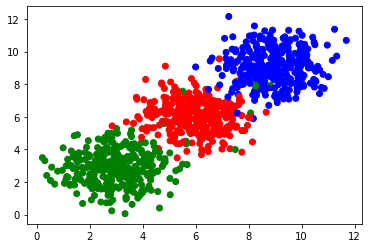

In [0]:
visualize_data(X)

In [0]:
X = generateData(1000, "c", noise=0.07, num_classes=5)

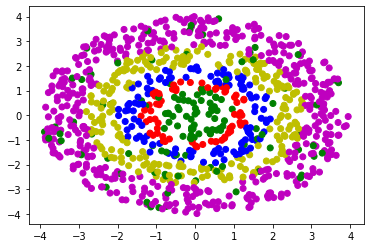

In [0]:
visualize_data(X)

## **c) [7pts] Train a small feedforward neural network.**

### Loss Functions

In [0]:
"""Squared Error Loss Function
Takes y and t of shape (m, outputs)
returns (m, 1) errors"""
def SquaredLoss(y, t):
  m = t.shape[0]
  err = (t - y)
  errors = np.square(err)
  errors = (errors.sum(axis=0).reshape(-1,1)/(2)).ravel()
  return errors[0], err

In [0]:
# Test Case
y = np.array([0,1,0,1])
t = np.array([0,0,1,1])
SquaredLoss(y, t)

(1.0, array([ 0, -1,  1,  0]))

In [0]:
"""Cross Entropy Loss Function
Takes y and t of shape (m, classes)
returns (m, 1) errors and dL/dz"""
def CrossEntropy(y, t_ohv):
  m = y.shape[0]
  t = np.argmax(t_ohv, axis=1)
  loss = np.sum(-np.log(y[np.arange(m), t]))
  grad = y
  grad[np.arange(m), t] -= 1
  grad = -grad/m
  return loss, grad

In [0]:
# Test Case
y = np.array([[0.25,0.25,0.25,0.25], [0.01,0.01,0.01,0.96]])
t = np.array([[0,0,0,1], [0,0,0,1]])
CrossEntropy(y, t)

(1.4271163556401458, array([[-0.125, -0.125, -0.125,  0.375],
        [-0.005, -0.005, -0.005,  0.02 ]]))

### Activiation Functions

In [0]:
z = np.arange(-5,5,1)

In [0]:
"""Linear Function
Takes input Z of (m, 1)
returns (m, 1) and da/dz
"""
def linear(z):
  diff = np.ones_like(z)
  return (z, diff)

In [0]:
linear(z)

(array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [0]:
"""ReLu Function
Takes input Z of (m, 1)
returns (m, 1) and da/dz
"""
def ReLU(z):
  out = np.maximum(z, 0)
  diff = z
  diff[diff>0] = 1
  diff[diff<0] = 0
  return (out, diff)

In [0]:
# Test Case
ReLU(z)

(array([0, 0, 0, 0, 0, 0, 1, 2, 3, 4]), array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1]))

In [0]:
"""Sigmoid Function
Takes input Z of (m, 1)
returns (m, 1) and da/dz
"""
def sigmoid(z, diff=False):
  warnings.filterwarnings('ignore')
  e_z = np.exp(-z)
  warnings.filterwarnings('default')
  sig = 1/(1 + e_z)
  diff = sig * (1 - sig)
  return sig, diff

In [0]:
# Test Case
sigmoid(z)

(array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.73105858, 0.73105858, 0.73105858, 0.73105858]),
 array([0.25      , 0.25      , 0.25      , 0.25      , 0.25      ,
        0.25      , 0.19661193, 0.19661193, 0.19661193, 0.19661193]))

In [0]:
"""Softmax Function
Takes input of (m, num_class)
returns (m, num_classes_probability) and z_bar
"""
def softmax(z):
  z -= np.max(z, axis=1, keepdims=True)
  e_z = np.exp(z)
  e_z_sum = np.sum(e_z, axis=1, keepdims=True) 
  p = e_z/e_z_sum
  return p, None

In [0]:
z = np.arange(1000, 1010).reshape(2, 5)
y = np.array([[0,0,1,0,0],[0,1,0,0,0]])
print("Y shape", y.shape)
softmax(z)

Y shape (2, 5)


(array([[0.01165623, 0.03168492, 0.08612854, 0.23412166, 0.63640865],
        [0.01165623, 0.03168492, 0.08612854, 0.23412166, 0.63640865]]), None)

### Train, Pedict, Decision Boundry Functions

In [0]:
def train(X, numInput, numHiddenUnits, numOutput, activationType, numIter, lr=0.001, weights=None, verbose=True, numHiddenLayers=2):
  m = X.shape[0]

  # Random Weight Initialization
  assert numHiddenLayers>=2, "Minimum layers must be 2, including output Layer and Excluding Input layers"
  W = [None]
  if weights is None:
    for i in range(1, numHiddenLayers+1):
      if i is 1:
        Wi = 2*np.random.rand(numInput+1, numHiddenUnits) - 1
      elif i is numHiddenLayers:
        Wi = 2*np.random.rand(numHiddenUnits, numOutput) - 1
      else:
        Wi = 2*np.random.rand(numHiddenUnits, numHiddenUnits) - 1
      W.append(Wi)
  else:
    W = weights

  assert len(W)==numHiddenLayers+1, "Assertion failed for weights"


  # Extract x and y
  x, t = X[:, :numInput], X[:,numInput:]
  b = np.ones((m,1))
  x = np.hstack((x, b))

  ai_fun = None
  al_fun = sigmoid
  
  if numOutput > 1:
    al_fun = softmax


  if activationType is "relu" or activationType is "R":
    ai_fun = ReLU
  elif activationType is "linear" or activationType is "L":
    ai_fun = linear
  elif activationType is "sigmoid" or activationType is "S":
    ai_fun = sigmoid
  else:
    raise Exception(f"{activationType} not supported")

  losses = []
    
  for i in tqdm(range(numIter), total=numIter, disable=not(verbose)):
    a = [x]
    a_diff = [np.ones_like(x)]
    ########### Forward pass #########
    for i in range(1, numHiddenLayers+1):
      Zi = np.dot(a[i-1], W[i])
      if i is numHiddenLayers:
        ai, ai_diff = al_fun(Zi)
      else:
        ai, ai_diff = ai_fun(Zi)
      a.append(ai)
      a_diff.append(ai_diff)

    ########### Backward Pass ########
    y = a[-1]
    if al_fun is sigmoid:
      error, loss_diff = SquaredLoss(y, t)
      al_bar = loss_diff
      zl_bar = al_bar * a_diff[-1]
    else:
      error, zl_bar = CrossEntropy(y, t)

    losses.append(error)
    wl_bar = np.dot(a[-2].T, zl_bar)
    W[-1] = W[-1] + lr * wl_bar

    w_bar = [None for i in range(numHiddenLayers)]
    w_bar.append(wl_bar)

    z_bar = [None for i in range(numHiddenLayers)]
    z_bar.append(zl_bar)

    for j in range(1, numHiddenLayers):
      i = -(j+1)
      ai_bar = np.dot(z_bar[i+1], W[i+1].T)
      zi_bar = ai_bar * a_diff[i] 
      z_bar[i] = zi_bar 

      wi_bar = np.dot(a[i-1].T, zi_bar)
      w_bar[i] = wi_bar
      W[i] = W[i] + lr * wi_bar
    
    # print("*********************END************************")
  if verbose is True:
    plt.plot(losses)
    print("loss=", losses[-1])
  
  return W[1:]

In [0]:
def predict_multi_weight(X, W, numInput, numHiddenUnits, numOutput, activationType, verbosity, numHiddenLayers=2):
  m, f = X.shape
  x, t = X[:, :numInput], X[:,numInput:]
  
  b = np.ones((m,1)).reshape(m,1)
  x = np.hstack((x, b))
  
  ai_fun = None
  al_fun = sigmoid
  
  if numOutput > 1:
    al_fun = softmax


  if activationType is "relu" or activationType is "R":
    ai_fun = ReLU
  elif activationType is "linear" or activationType is "L":
    ai_fun = linear
  elif activationType is "sigmoid" or activationType is "S":
    ai_fun = sigmoid
  else:
    raise Exception(f"{activationType} not supported")

  losses = []

  a = [x]
  ########### Forward pass #########
  for i in range(1, numHiddenLayers+1):
    Zi = np.dot(a[i-1], W[i])
    if i is numHiddenLayers:
      ai, ai_diff = al_fun(Zi)
    else:
      ai, ai_diff = ai_fun(Zi)
    a.append(ai)
  return a[-1]

In [0]:
def predict( X, W1, W2, numInput, numHiddenUnits, numOutput, activationType, verbosity ):
  m, f = X.shape
  x, t = X[:, :numInput], X[:,numInput:]
  W = [None, W1, W2]
  y = predict_multi_weight(X, W, numInput, numHiddenUnits, numOutput, activationType, False, 2);
  # Cross Entropy Loss
  t = t.astype(np.int64)
  if numOutput is 1:
    loss = - (t * np.log(y) + (1-t) * np.log(1-y))
  else:
    t = t.argmax(axis=1)
    loss = -np.log(y[np.arange(m), t])[:, np.newaxis]
  output = np.hstack((y, loss))
  return output


In [0]:
def plot_decision_boundry(W1, W2, X_train, activationType='relu'):
  numHiddenUnits=W1.shape[1]
  numOutput=W2.shape[1]
  max_val = np.max(X_train) + 0.5
  min_val = np.min(X_train) - 0.5
  x_range = np.linspace(min_val, max_val, 100)
  x1, x2 = np.meshgrid(x_range, x_range)
  X = np.array([x1.ravel(),x2.ravel()]).T
  if numOutput > 1:
    y = np.random.randint(0, numOutput, size=(10000, 1))
    y = one_hot_vector(y)
    X = np.hstack((X, y))
  else:
    X = np.append( X, np.ones((100*100,1)), axis=1 )
    
  output = predict(X, W1, W2, 2, numHiddenUnits, numOutput, activationType, verbosity=False)
  y_pred, loss = output[:,:-1], output[:,-1][:, np.newaxis]
  if y_pred.shape[1] == 1:
    print("Binary Classification")
    y_pred = np.round(y_pred)
  else:
    y_pred = np.argmax(y_pred, axis=1).reshape(-1,1)

  X = np.hstack((X[:,:-1], y_pred))
  plt.contourf(x1,x2, y_pred.reshape(100, 100))
  visualize_data(X_train)
  return

### Training on 2 Clusters and visualizing Decision Boundries

100%|██████████| 1500/1500 [00:00<00:00, 4231.76it/s]


loss= 10.442916878397902


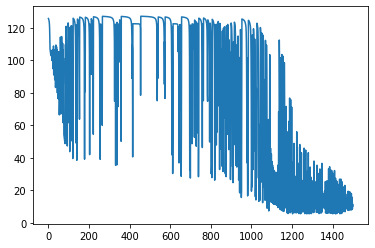

In [0]:
c = 2
out_nodes = 1
act='relu'
hidden_units = 15
lr = 0.01
X = generateData(500, "g", noise=0.02, num_classes=c)

np.random.seed(10)
W1, W2 = train(X, numInput=2, numHiddenUnits=hidden_units, numOutput=out_nodes, activationType=act, numIter=1500)

Binary Classification


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


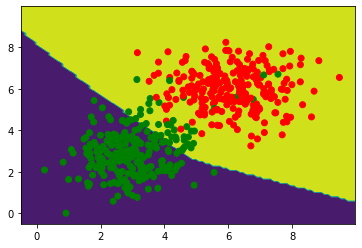

In [0]:
plot_decision_boundry(W1, W2, X, act)

### Multi Class Gaussian 

100%|██████████| 10000/10000 [00:04<00:00, 2483.09it/s]


loss= 207.1549637826206


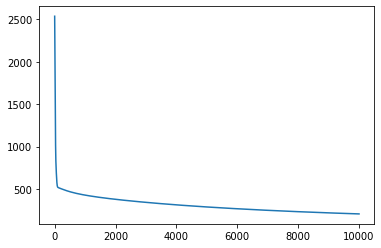

In [0]:
c = 3
out_nodes = c
act='relu'
hidden_units = 15
lr = 0.01
X = generateData(500, "g", noise=0.02, num_classes=c)

np.random.seed(10)
W1, W2 = train(X, numInput=2, numHiddenUnits=hidden_units, numOutput=out_nodes, activationType=act, numIter=10000)

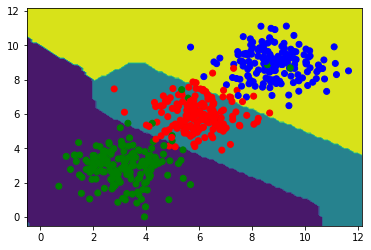

In [0]:
plot_decision_boundry(W1, W2, X, act)

### Training on 2 Concentric Circles and visualizing Decision Boundries

100%|██████████| 5000/5000 [00:01<00:00, 4392.23it/s]


loss= 6.624009230481222


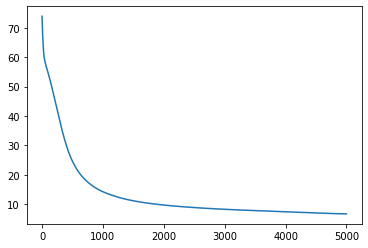

In [0]:
c = 2
out_nodes = 1
act='relu'
hidden_units = 15
lr = 0.01

X = generateData(500, "c", noise=0.02)
np.random.seed(22)
W1, W2 = train(X, numInput=2, numHiddenUnits=10, numOutput=out_nodes, activationType=act, numIter=5000)

Binary Classification


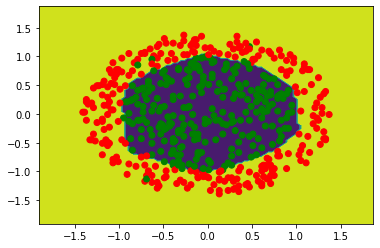

In [0]:
plot_decision_boundry(W1, W2, X)

### Training on 3 Concentric Circles and visualizing Decision Boundries

100%|██████████| 20000/20000 [00:09<00:00, 2174.85it/s]


loss= 130.61202583638203


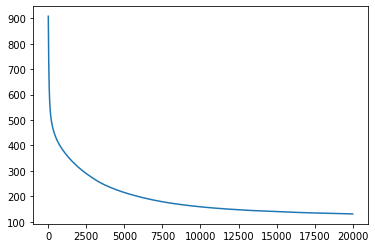

In [0]:
c = 3
out_nodes = 3
act='relu'
hidden_units = 15
lr = 0.01

X = generateData(500, "c", noise=0.02, num_classes=c)
np.random.seed(22)
W1, W2 = train(X, numInput=2, numHiddenUnits=15, numOutput=out_nodes, activationType=act, numIter=20000, lr=lr)

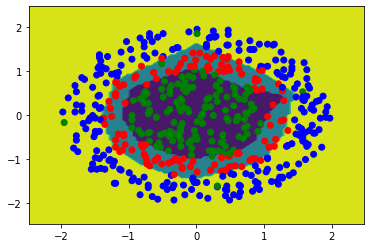

In [0]:
plot_decision_boundry(W1, W2, X)

## d) [5pts] Refactor

In [0]:
class Model:
  def __init__(self, numInputs=2, numOutputs=1, layerSize=2, numHiddenLayers=2, activationType='R'):
    self.numInputs = numInputs
    self.numOutputs = numOutputs
    self.layerSize = layerSize
    self.numHiddenLayers = numHiddenLayers
    self.activationType = activationType

  def setWeights(self, W):
    self.W = W
    return
  
  def initWeights(self, mean=0.0, stdev=0.01):
    self.W = [None]

    for i in range(1, self.numHiddenLayers+1):
      if i is 1:
        Wi = np.random.normal(loc=mean, 
                               scale=stdev, 
                               size=(self.numInputs+1, self.layerSize))
      elif i is self.numHiddenLayers:
        Wi = np.random.normal(loc=mean, 
                               scale=stdev, 
                               size=(self.layerSize, self.numOutputs))
      else:
        Wi = np.random.normal(loc=mean, 
                               scale=stdev, 
                               size=(self.layerSize, self.layerSize))
      self.W.append(Wi)
    return

  def setInput(self, X_train):
    self.X_train = X_train
    return

  def setTest(self, X_test):
    self.X_test = X_test
    return

  def train(self, epochs=100, lr=0.01):
    # Returns n errors for test and train where n is num of epochs
    train_loss = []
    test_loss = []
    for epoch in tqdm(range(epochs), total=epochs):
      W = train(self.X_train, self.numInputs, self.layerSize,
                self.numOutputs, self.activationType, 1, lr, self.W, False, self.numHiddenLayers)
      W.insert(0, None)
      self.setWeights(W)
      train_result = self.predict(self.X_train)
      tr_loss = np.average(train_result[:, -1])
      train_loss.append(tr_loss)
      
      test_result = self.predict(self.X_test)
      te_loss = np.average(test_result[:, -1])
      test_loss.append(te_loss)
    
    train_loss = np.array(train_loss).reshape(-1, 1)
    test_loss = np.array(test_loss).reshape(-1, 1)
    return np.hstack((train_loss, test_loss))

  def test(self):
    # Returns error on test set
    test_result = self.predict(self.X_test)
    return np.sum(test_result[:, -1])

  def predict(self, X):
    return predict_multi_weight(X, self.W, self.numInputs, self.layerSize,
            self.numOutputs, self.activationType, False, self.numHiddenLayers);

### e) [1pt] [new] : Allow a variable number of hidden units.

100%|██████████| 2000/2000 [00:03<00:00, 637.23it/s]


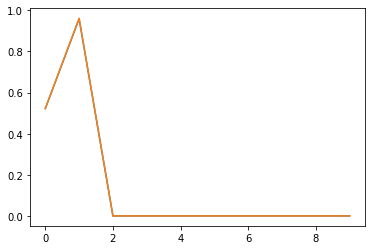

In [0]:
np.random.seed(10)
X_train = generateData(1000, 'g', 0.02, 2 )
X_test = generateData(100, 'g', 0.02, 2 )
net = Model(layerSize=15, numOutputs=1, numHiddenLayers=2)
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(0.0,0.01)
trainError = net.train(2000, 0.01)
plt.plot(trainError[0:10,0])
plt.plot(trainError[0:10,1])

In [0]:
net.test()

0.006387317709482873

### f) [1pt] [new] : Allow the various possible activation types

100%|██████████| 2000/2000 [00:04<00:00, 460.72it/s]


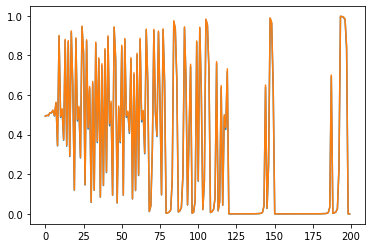

In [0]:
net = Model(layerSize=15, numOutputs=1, numHiddenLayers=2, activationType='S')
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(0.0,0.01)
trainError = net.train(2000, 0.01)
plt.plot(trainError[0:200,0])
plt.plot(trainError[0:200,1])

### g) [1pt] [new] : Allow multiple output units, using softmax and a cross-entropy error.

100%|██████████| 5000/5000 [00:06<00:00, 738.58it/s]


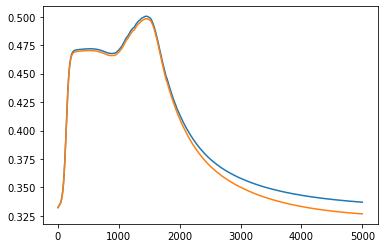

In [0]:
X_train = generateData(1000, 'g', 0.02, 3 )
X_test = generateData(100, 'g', 0.02, 3 )

net = Model(layerSize=15, numOutputs=3, numHiddenLayers=2)
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(0.0,0.01)
trainError = net.train(5000, 0.01)
plt.plot(trainError[0:5000,0])
plt.plot(trainError[0:5000,1])

### h) [1pt] [new] : Allow multiple hidden layers.


100%|██████████| 5000/5000 [00:06<00:00, 715.63it/s]


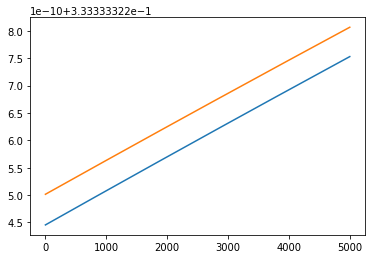

In [0]:
net = Model(layerSize=5, numOutputs=3, numHiddenLayers=4, activationType='R')
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(0.0,0.01)
trainError = net.train(5000, 0.01)
plt.plot(trainError[0:5000,0])
plt.plot(trainError[0:5000,1])

In [0]:
net.test()

32.999998957863994

# References 

[Softmax CrossEntropy by PARAS DAHAL](https://deepnotes.io/softmax-crossentropy)

Roger Gross Notes (For Conventions)
